In [1]:
import pandas as pd
import cv2
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
#from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import os
import argparse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
K.set_image_data_format('channels_last')
import logging

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras.metrics import CategoricalAccuracy
from tqdm import tqdm

2023-08-21 14:59:44.399377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 14:59:44.505053: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 14:59:44.992053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rkannan/miniconda3/envs/richard_tf/lib/python3.9/site-packages/cv2/../../lib64::/

python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
keras version 2.11.0
tensorflow version 2.11.0


In [2]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))
        
path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_NonCOVID/'
prefix2 = 'ct_noncovid'
# renameImageFiles(path1, prefix1,'png')
# renameImageFiles(path2, prefix2,'png')
# renameImageFiles(path2, prefix2,'jpg')

Input_x Data Shape: 
(4649, 300, 300, 1)
Output_y Data Shape: 
(4649, 2)


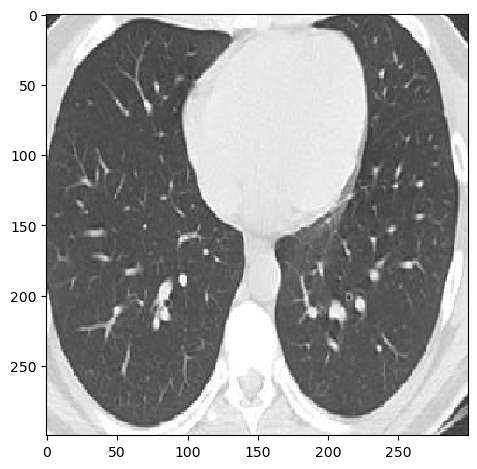

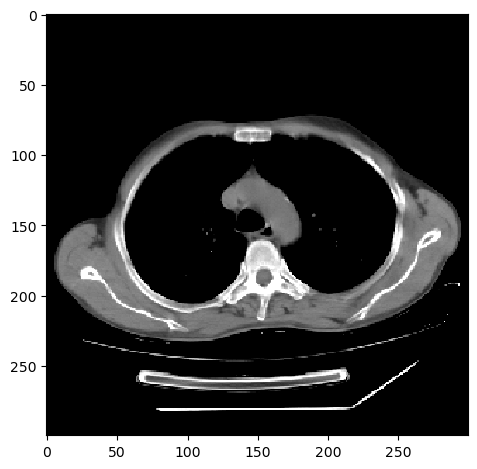

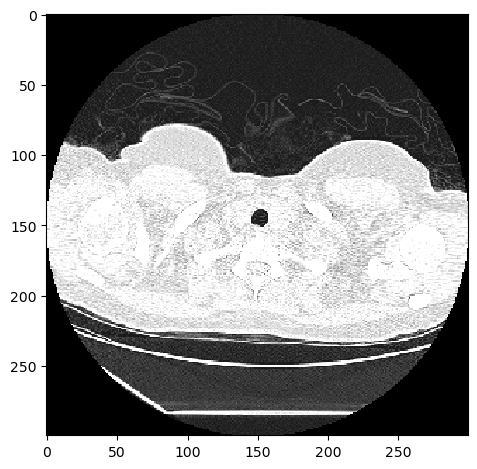

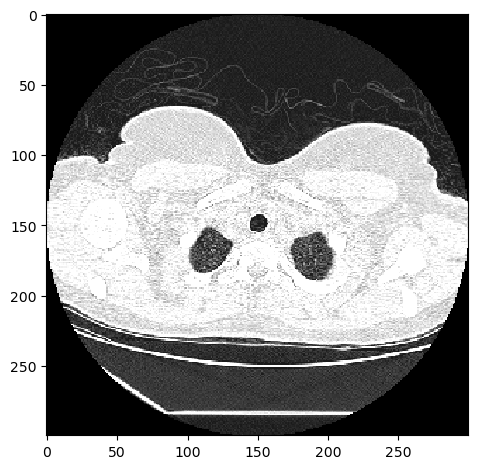

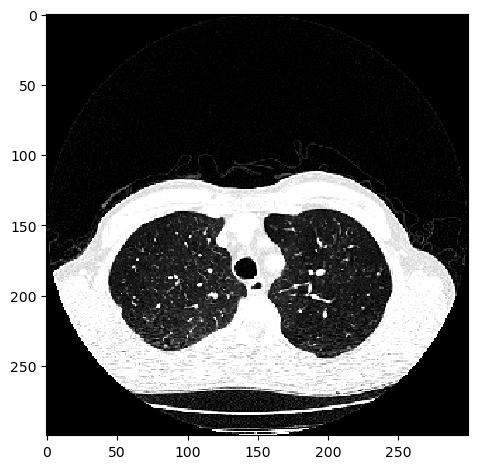

In [3]:
def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df 

ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
#Concatenating the two data frame to create a dataset ready for machine learning
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((4649,300,300,1))
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset[['output_encode_0','output_encode_1']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))

for i in range(5):
    imshow(input_data_x[i])
    show()

### Feature Scaling

#### **Splitting the dataset into the Training set and Test set**

In [4]:
from sklearn.model_selection import train_test_split
def splitData(input_data_x_, output_label_y_):
    x_train, x_test, y_train, y_test = train_test_split(input_data_x_, output_label_y_, test_size=.20, random_state=42)
    return (x_train, x_test), (y_train, y_test)

def get_data():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, x_test), (y_train, y_test) = splitData(input_data_x, output_label_y)
    #return x_train, x_test, y_train, y_test

    x_train = x_train[0:3200,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    x_test = x_test[0:920,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    y_train = y_train.astype('float32')[0:3200,:]
    y_test = y_test.astype('float32')[0:920,:]
    return (x_train, y_train), (x_test, y_test)

# load data
(x_train, y_train), (x_test, y_test) = get_data()
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(3200, 300, 300, 1) (3200, 2) (920, 300, 300, 1) (920, 2)


### Loading Dataset for Second Task

In [5]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))

path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((14486,300,300,1))#dataset1=746
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset_ = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset_[['output_encode_0','output_encode_1']])
#output_label_y = np.array(cvd_imgs_dataset[['output_encode']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))
#print('Output_y Data Shape for evaluation: \n{0}'.format(output_label_y_eval.shape))



libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
ct_covid_965.png,1,0,6,1,1,2,2,6,1,2,...,3,0,0,0,0,0,1,0,2,1
ct_noncovid_3061.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_5627.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_covid_1124.png,2,1,2,2,3,2,5,1,3,3,...,4,0,1,4,1,3,2,2,2,1
ct_covid_2421.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ct_noncovid_2060.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_6363.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_4295.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_300.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Input_x Data Shape: 
(14486, 300, 300, 1)
Output_y Data Shape: 
(14486, 2)


In [6]:
from sklearn.model_selection import train_test_split

def splitData(input_data_x_, output_label_y_):
    x_train, x_test, y_train, y_test = train_test_split(input_data_x_, output_label_y_, test_size=.50, random_state=42)
    return (x_train, x_test), (y_train, y_test)
def get_data():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, x_test), (y_train, y_test) = splitData(input_data_x, output_label_y)
    #return x_train, x_test, y_train, y_test
    #11580
    x_train = x_train[0:5000,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    x_test = x_test[0:7200,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    y_train = y_train.astype('float32')[0:5000,:]
    y_test = y_test.astype('float32')[0:7200,:]
    return (x_train, y_train), (x_test, y_test)

# load data
(x_train_gen_2, y_train_gen_2), (x_test_gen_2, y_test_gen_2) = get_data()
print(x_train_gen_2.shape, y_train_gen_2.shape,x_test_gen_2.shape, y_test_gen_2.shape)
#(3254, 300, 300, 1) (3254, 2) (1395, 300, 300, 1) (1395, 2)]=[;-----p]

(5000, 300, 300, 1) (5000, 2) (7200, 300, 300, 1) (7200, 2)


In [7]:
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'
        
def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels,image_predicted = model.predict((test_features_, test_labels_),20)
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    # df['Probality'] = np.max(np.array(df.iloc[:,:7]))
    #df.drop([0,1,2,3,4,5,6,7,8,9],axis =1,inplace=True)
    #print(df.head(100))
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()
    
    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    #pred_list = [i for i in range(test_labels_.shape[0]) if test_labels__[i] is predicted_labels[i]]

#     pred = model.evaluate(test_features_,test_labels_)
#     print("loss = " + str(pred[0]))
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__, 
                    predicted_labels=predictions)


    
def getModelLayer_info(model):
    # Create an empty list to store layer information
    layer_info = []

    # Iterate through model layers and collect information
    for layer in model.layers:
        layer_info.append({
            'Layer Name': layer.name,
            'Layer Type': layer.__class__.__name__,
            'Output Shape': layer.output_shape,
            'Trainable': layer.trainable,
        })

    # Convert layer information to a DataFrame
    layer_df = pd.DataFrame(layer_info)

    # Print the DataFrame
    return layer_df

def ModelTrainEvaluation(history_):
    # Plot loss and accuracy history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_['loss'])
    plt.plot(history_['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    #plt.legend(['Training loss','Validation loss'], loc = 'upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history_['accuracy'])
    plt.plot(history_['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    #plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')

    plt.tight_layout()
    plt.show()
    
def ModelTestEvaluation(model):
    loss, accuracy = model.evaluate(x_test_gen_2, y_test_gen_2)
    loss_base, accuracy_base = model.evaluate(x_test, y_test)
    print(f"Task 1 - EWC Loss: {loss_base:.4f}, EWC Accuracy: {accuracy_base:.4f}")
    print(f"Task 2 - EWC Loss: {loss:.4f}, EWC Accuracy: {accuracy:.4f}")
    print()

### Capsule Network Development
#### Capsule Layers

- https://fairyonice.github.io/Understanding-and-Experimenting-Capsule-Networks.html
- https://www.youtube.com/watch?v=VKoLGnq15RM&t=912s
- https://jhui.github.io/2017/11/03/Dynamic-Routing-Between-Capsules/
- https://www.kaggle.com/code/kmader/capsulenet-on-mnist/notebook

In [8]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        #print('From Me',inputs_hat.shape)
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    print(outputs.shape)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""


'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

### Capsule Network

In [9]:
def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape, batch_size=batch_size)
    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=106, kernel_size=6, strides=2, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=6, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(628, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1448, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
    #decoder.summary()

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    return train_model, eval_model

In [10]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

### Training

In [11]:
from tensorflow.keras.metrics import BinaryAccuracy  # Import BinaryAccuracy for binary classification
from tqdm import tqdm

def train_task_with_ewc(task_model, x_train, y_train, x_train_val, y_train_val, prior_weights, task_epochs, regularization_strength, batch_size):
    optimizer = tf.keras.optimizers.Adam()  # Define the optimizer
    batch_size = batch_size
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}  # To store loss and accuracy history
    
    for epoch in tqdm(range(task_epochs)):
        num_batches = len(x_train[0]) // batch_size
        #print(f"Epoch {epoch + 1}/{task_epochs}")
        # Training
        total_loss = 0
        total_accuracy = 0
        total_val_loss = 0
        total_val_accuracy = 0

        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            with tf.GradientTape() as tape:
                logits,_ = task_model([x_train[0][start:end],x_train[1][start:end]])
                task_loss = tf.losses.binary_crossentropy(y_train[0][start:end], logits, from_logits=True)  # Use binary_crossentropy
                regularization_loss = compute_ewc_regularization(task_model, prior_weights)
                total_loss_batch = task_loss + regularization_strength * regularization_loss
            gradients = tape.gradient(total_loss_batch, task_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, task_model.trainable_variables))
            total_loss += tf.reduce_sum(total_loss_batch)
            total_accuracy += BinaryAccuracy()(y_train[0][start:end], logits)  # Use BinaryAccuracy for binary classification

        # Calculate and print average loss and accuracy
        avg_total_loss = total_loss / num_batches
        avg_total_accuracy = total_accuracy / num_batches
        history['loss'].append(avg_total_loss.numpy())
        history['accuracy'].append(avg_total_accuracy.numpy())
        
    return history

# Compute EWC regularization loss
def compute_ewc_regularization(task_model, prior_weights):
    ewc_loss = 0
    for current_weights, prior_weights in zip(task_model.trainable_variables, prior_weights):
        ewc_loss += tf.reduce_sum(tf.square(current_weights - prior_weights))
    return ewc_loss

### Training on Task 1(Base Model)

In [12]:
model, eval_model = CapsNet(input_shape=x_test.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_test, 1))),
                                              routings=7,
                                              batch_size=20)#20
model_= model
model_.load_weights('result/trained_model_july1.h5')
model_.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})

2023-08-21 15:03:27.002764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 15:03:28.530308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14759 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-08-21 15:03:28.530939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14759 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-08-21 15:03:28.531510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

(20, 165888, 8)


### Training on Task 2 (Task Specific Model)

In [18]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
model_ewc, eval_model_ewc = CapsNet(input_shape=x_test.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_test, 1))),
                                              routings=7,
                                              batch_size=20)#20
model_ewc.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})
input_shape = x_train_gen_2.shape[1:]
num_classes = 2
task_epochs = 50
regularization_strength = 1.7#best = 2.0
batch_size = 20

x_train_gen_2_modified = [x_train_gen_2, y_train_gen_2]
y_train_gen_2_modified = [y_train_gen_2, x_train_gen_2]
val_features_gen_2 = None
val_labels_gen_2 = None
# Train task model with EWC regularization
history = train_task_with_ewc(model_ewc, x_train_gen_2_modified, y_train_gen_2_modified,val_features_gen_2, val_labels_gen_2,
                              model_.trainable_variables, task_epochs, regularization_strength,batch_size)

(20, 165888, 8)


100%|████████████████████████████████████████| 50/50 [1:24:01<00:00, 100.84s/it]


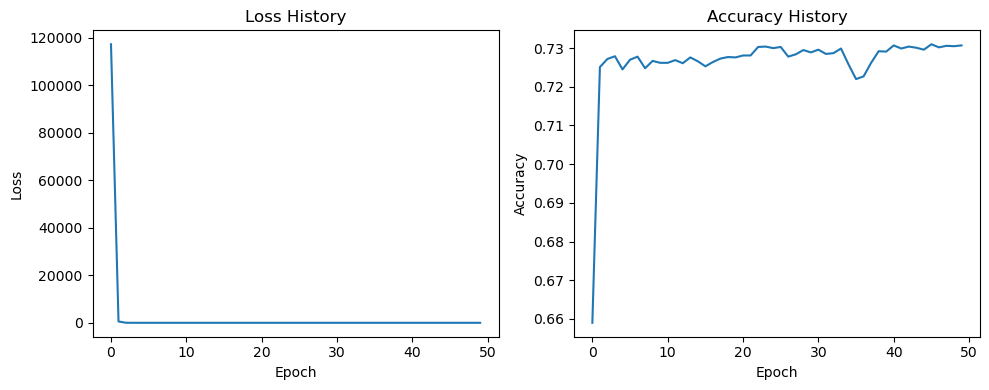

In [19]:
ModelTrainEvaluation(history)

360/360 [==============================] - 37s 102ms/step


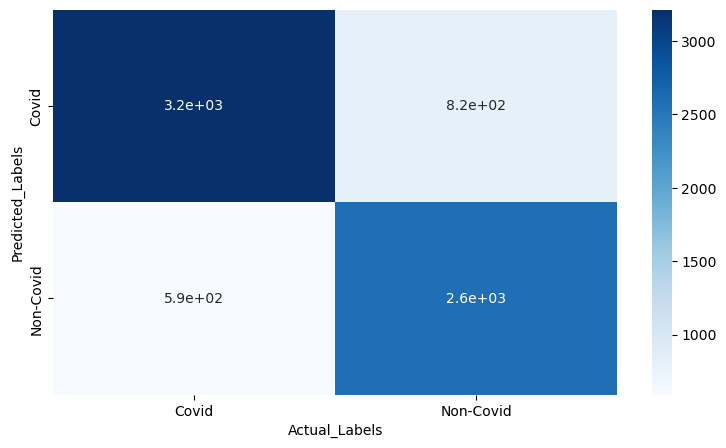

test accuracy = 80.34722222222223%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8035
Precision: 0.804
Recall: 0.8035
F1 Score: 0.8029


In [20]:
import seaborn as sns
getModelEvaluation(model_ewc,x_test_gen_2, y_test_gen_2)

46/46 [==============================] - 5s 102ms/step


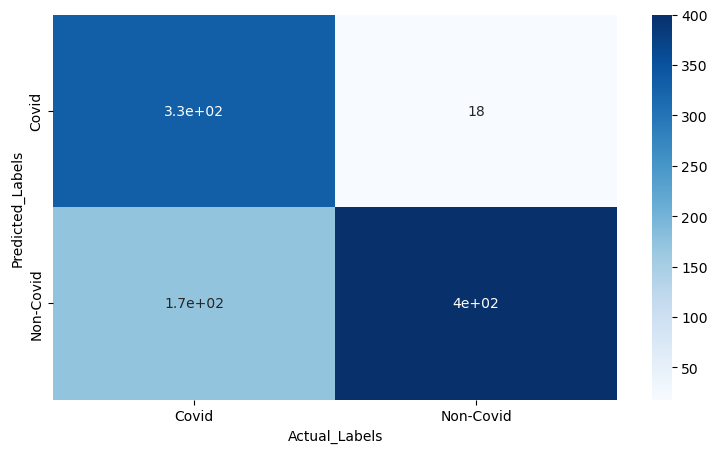

test accuracy = 79.34782608695652%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7935
Precision: 0.8352
Recall: 0.7935
F1 Score: 0.7908


In [21]:
getModelEvaluation(model_ewc ,x_test, y_test)

In [17]:
model_ewc.save('myCapsuleNet_ECW.h5')
model_ewc.save_weights('myCapsuleNet_weight_ECW.h5')